In [46]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    if len(images.shape) == 1:
        images = np.expand_dims(images, axis = 0)
        print(images.shape)
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params(model):
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
    return param_count


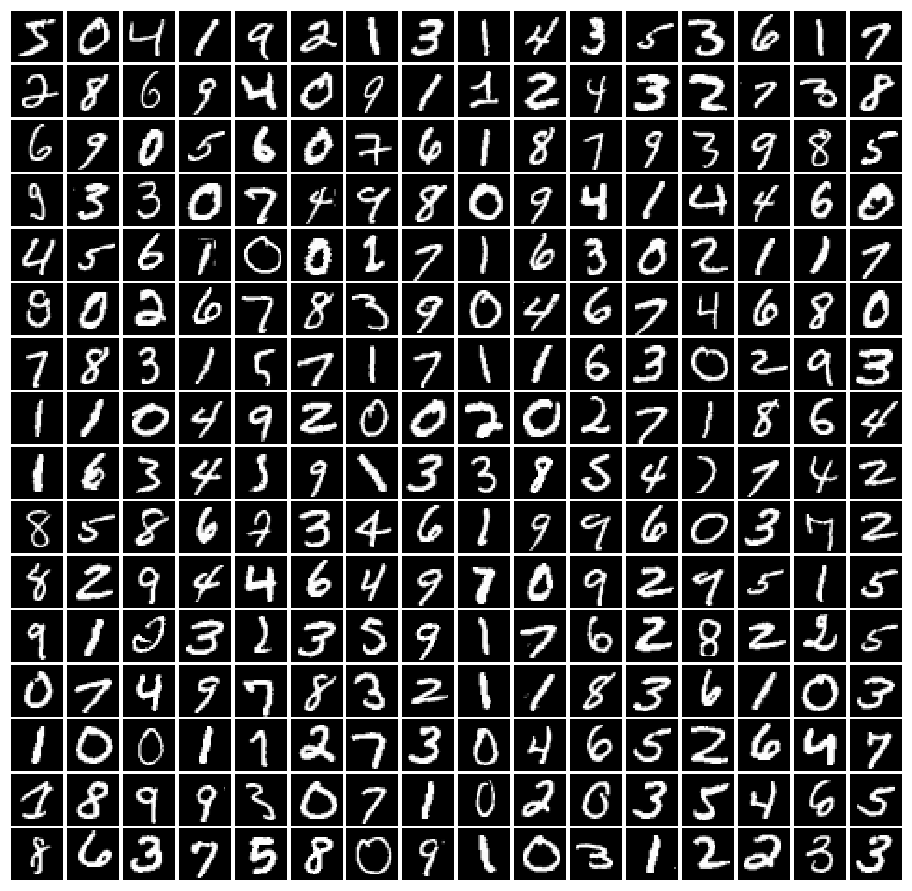

In [184]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 20
batch_size = 256

mnist_train = dset.MNIST('./datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

In [185]:
dir(loader_train)
print(loader_train.__len__())

196


In [186]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)
    
class Unflatten(nn.Module):
    """
    An Unflatten module receives an input of shape (N, C*H*W) and reshapes it
    to produce an output of shape (N, C, H, W).
    """
    def __init__(self, N=-1, C=128, H=7, W=7):
        super(Unflatten, self).__init__()
        self.N = N
        self.C = C
        self.H = H
        self.W = W
    def forward(self, x):
        return x.view(self.N, self.C, self.H, self.W)
    
def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
        init.xavier_uniform_(m.weight.data)

In [187]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

In [188]:
def unit_Gaussian(batch_size, dim):
    return torch.randn(batch_size, dim).type(dtype)

In [189]:
def sample_noise(encoder_mean, encoder_var, unit_Gaussian_var):
    """
    Generate a PyTorch Tensor of Gaussian random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing Gaussian
      random noise in the range (-1, 1).
    """
    if len(unit_Gaussian_var.shape) == 1:
        unit_Gaussian_var = torch.unsqueeze(unit_Gaussian_var, dim = 0)
    batch_size, dim = unit_Gaussian_var.size()
    list_sample_noise = torch.sqrt(encoder_var) * unit_Gaussian_var + encoder_mean
    return list_sample_noise

In [190]:
unit_Gaussian_var = unit_Gaussian(20, 6)
print(unit_Gaussian_var)
sample_noise(torch.zeros(6).type(dtype), torch.ones(6).type(dtype), unit_Gaussian_var)

tensor([[ 0.8692,  0.5293, -0.4752, -0.0690,  1.1202, -0.7271],
        [ 0.3625, -0.8461, -0.8360, -0.1943, -1.4644, -0.3299],
        [-0.6384, -0.3268, -0.1051, -1.3246,  1.9268,  2.1120],
        [-0.0028,  1.4511, -1.0162, -0.3699,  1.7552, -1.1485],
        [-0.0268,  0.4700,  0.3739, -0.0642,  0.5366,  0.2090],
        [-0.2203, -0.4870, -0.1087,  0.0263, -1.6487,  0.2101],
        [-1.0841,  1.4632,  0.4705,  0.6243,  1.4106,  0.4243],
        [-0.6413, -0.1936, -0.4192, -1.6681, -1.2247,  0.2073],
        [-0.0888, -1.4158,  0.5680, -1.8540, -0.0125, -0.6557],
        [ 0.8546,  0.4020,  0.2055, -0.7839,  1.4794,  0.0031],
        [-0.7824, -0.7098,  0.1494, -1.2188,  1.2700,  0.9791],
        [ 0.1908,  1.3056, -0.0523, -0.2892,  1.2075,  0.6125],
        [-1.0863,  1.9998,  0.4887, -0.4678, -0.2057,  1.2281],
        [ 0.9114, -1.0336,  0.0917, -0.0090,  0.6159, -2.0489],
        [ 0.6007,  1.2167,  0.0210, -1.7403,  0.9425, -0.9475],
        [-0.3496,  0.5040, -0.7285,  0.2

tensor([[ 0.8692,  0.5293, -0.4752, -0.0690,  1.1202, -0.7271],
        [ 0.3625, -0.8461, -0.8360, -0.1943, -1.4644, -0.3299],
        [-0.6384, -0.3268, -0.1051, -1.3246,  1.9268,  2.1120],
        [-0.0028,  1.4511, -1.0162, -0.3699,  1.7552, -1.1485],
        [-0.0268,  0.4700,  0.3739, -0.0642,  0.5366,  0.2090],
        [-0.2203, -0.4870, -0.1087,  0.0263, -1.6487,  0.2101],
        [-1.0841,  1.4632,  0.4705,  0.6243,  1.4106,  0.4243],
        [-0.6413, -0.1936, -0.4192, -1.6681, -1.2247,  0.2073],
        [-0.0888, -1.4158,  0.5680, -1.8540, -0.0125, -0.6557],
        [ 0.8546,  0.4020,  0.2055, -0.7839,  1.4794,  0.0031],
        [-0.7824, -0.7098,  0.1494, -1.2188,  1.2700,  0.9791],
        [ 0.1908,  1.3056, -0.0523, -0.2892,  1.2075,  0.6125],
        [-1.0863,  1.9998,  0.4887, -0.4678, -0.2057,  1.2281],
        [ 0.9114, -1.0336,  0.0917, -0.0090,  0.6159, -2.0489],
        [ 0.6007,  1.2167,  0.0210, -1.7403,  0.9425, -0.9475],
        [-0.3496,  0.5040, -0.7285,  0.2

In [191]:
unit_Gaussian_var = unit_Gaussian(50000, 6)
sample_noise(torch.zeros(6).type(dtype), torch.ones(6).type(dtype), unit_Gaussian_var)

tensor([[ 2.5350e+00,  8.3423e-01, -1.0637e+00, -1.6940e+00, -7.4211e-01,
          2.2326e-02],
        [ 2.0626e-01, -5.9523e-01, -3.4324e-01, -7.0274e-01,  1.4593e+00,
          3.6754e-01],
        [-1.6328e+00,  2.9772e-02,  2.6009e-01, -1.0745e+00,  8.6570e-01,
          3.6332e-01],
        ...,
        [ 5.9553e-01, -6.0622e-03,  6.1638e-01, -1.2696e+00, -3.2144e-01,
         -1.1911e+00],
        [-5.0572e-01,  8.7779e-02, -2.2220e+00, -7.8496e-01,  2.2314e+00,
         -2.7594e-01],
        [-6.7112e-01,  5.3912e-02, -5.3873e-01,  1.0710e+00,  1.5789e+00,
         -1.0231e+00]], device='cuda:0')

In [192]:
def encoder_mean(noise_dim=NOISE_DIM):
    """
    Build and return a Pytorch model implementing the architecture above.
    """
    model = nn.Sequential(
        Flatten(),
        nn.Linear(784, 256),
        nn.LeakyReLU(0.01, inplace=True),
        nn.Linear(256, noise_dim),
    )
    return model

In [193]:
def encoder_var(noise_dim=NOISE_DIM):
    """
    Build and return a Pytorch model implementing the architecture above.
    """
    model = nn.Sequential(
        Flatten(),
        nn.Linear(784, 256),
        nn.LeakyReLU(0.01, inplace=True),
        nn.Linear(256, noise_dim),
        nn.Softplus()
    )
    return model

In [194]:
def KL_divergence_loss(encoder_mean, encoder_var):
    """
    Computes the KL divergence loss described above.
    
    Inputs:
    - encoder_mean: PyTorch Variable of shape (N,) giving scores for the average of z.
    - encoder_var: PyTorch Variable of shape (N,) giving scores for the variance of z.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    """
    encoder_mean = torch.squeeze(encoder_mean)
    encoder_var = torch.squeeze(encoder_var)
    k = encoder_mean.size()
    encoder_var_matrix = torch.diag(encoder_var)    
    loss = 0.5 * (torch.trace(encoder_var_matrix) + torch.sum(encoder_mean * encoder_mean) - torch.tensor(k).type(dtype) - torch.logdet(encoder_var_matrix))
    """
    N, k = encoder_mean.size()
    loss = 0.5 / N  * (torch.sum(encoder_var) + torch.sum(encoder_mean ** 2) - torch.tensor(N * k).type(dtype) - torch.sum(torch.log(torch.prod(encoder_var, dim = 1))))
    return loss

In [195]:
def test_KL_divergence_loss(encoder_mean, encoder_var):
    d_loss = KL_divergence_loss(Variable(torch.Tensor(encoder_mean)).type(dtype),
                                Variable(torch.Tensor(encoder_var)).type(dtype)).data.cpu().numpy()
    print("d_loss: %g"%d_loss)

test_KL_divergence_loss(torch.zeros(5, 6), torch.ones(5, 6)) 


d_loss: 0


In [196]:
def Resconstruct_loss(input, target):
    """
    Computes the reconstruct loss described above.
    
    Inputs:
    - input: PyTorch Variable of shape (N,) giving scores for the average of z.
    - target: PyTorch Variable of shape (N,) giving scores for the variance of z.
    
    Returns:
    - loss: PyTorch Variable containing (scalar) the loss for the discriminator.
    """
    N, C, H, W =input.size()
    loss = torch.sum((input - target) * (input - target)) / (N )
    
    return loss

In [197]:
def test_Resconstruct_loss(input, target):
    d_loss = Resconstruct_loss(Variable(torch.Tensor(input)).type(dtype),
                                Variable(torch.Tensor(target)).type(dtype)).data.cpu().numpy()
    print("d_loss: %g"%d_loss)

test_Resconstruct_loss(torch.zeros(5,6,8,9), torch.ones(5,6,8,9)) 

d_loss: 432


In [198]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.
    
    Input:
    - model: A PyTorch model that we want to optimize.
    
    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr = 0.001,  betas=(0.5, 0.999))
    return optimizer

In [199]:
def decoder(noise_dim=NOISE_DIM):
    """
    Build and return a PyTorch model for the decoder implementing
    the architecture before
    """
    """
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace = True),
        nn.Linear(1024, 7 * 7 * 128),
        nn.ReLU(inplace = True),
        Unflatten(batch_size, 128, 7, 7),
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride = 2, padding = 1),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = 4, stride = 2, padding = 1),
        nn.Sigmoid() 
    """
    """
    return nn.Sequential(
        nn.Linear(noise_dim, 400),
        nn.ReLU(inplace = True),
        nn.Linear(400, 784),
        Unflatten(batch_size, 1, 28, 28),
        nn.Sigmoid() 
    )
    """
    return nn.Sequential(
        nn.Linear(noise_dim, 1024),
        nn.ReLU(inplace = True),
        nn.Linear(1024, 7 * 7 * 128),
        nn.ReLU(inplace = True),
        Unflatten(batch_size, 128, 7, 7),
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 4, stride = 2, padding = 1),
        nn.ReLU(inplace = True),
        nn.ConvTranspose2d(in_channels = 64, out_channels = 1, kernel_size = 4, stride = 2, padding = 1),
        nn.Sigmoid()  
    )
    

In [205]:
def run_a_vae(E_mean, E_var, D, E_mean_solver, E_var_solver, D_solver, KL_divergence_loss, generator_loss, show_every=250, 
              batch_size=batch_size, noise_size=NOISE_DIM, num_epochs=10):
    """
    Train a VAE!
    
    Inputs:
    - E_mean, E_var, D: PyTorch models for the discriminator and generator
    - E_solver, D_solver: torch.optim Optimizers to use for training the
      encoder and decoder.
    - KL_divergence_loss, Resconstruct_loss: Functions to use for computing the encoder and
      decoder loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training, in VAE, default value is 1.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    """
    iter_count = 0

    #unit_Gaussian_var = unit_Gaussian(NUM_TRAIN, NOISE_DIM)
    
    for epoch in range(num_epochs):
        inner_count = 0
        for x, _ in loader_train:
            #print(x)
            #print(x.size())
            #print(unit_Gaussian_var.size())
            N, _, _, _ = x.size()
            unit_Gaussian_var = unit_Gaussian(NUM_TRAIN, NOISE_DIM)
            unit_Gaussian_var_sample = unit_Gaussian_var[inner_count:inner_count + N,:]

    
            if len(x) != batch_size:
                continue
            E_mean_solver.zero_grad()
            E_var_solver.zero_grad()
            D_solver.zero_grad()
            
            real_data = Variable(x, requires_grad = False).type(dtype)
            E_mean_result = E_mean(real_data).type(dtype)
            E_var_result = E_var(real_data).type(dtype)

            d_KL_loss = KL_divergence_loss(E_mean_result, E_var_result)
            latent_variable = sample_noise(E_mean_result, E_var_result, unit_Gaussian_var_sample).type(dtype)
            decoder_result = D(latent_variable).type(dtype)
                      
            d_recons_error = generator_loss(decoder_result, real_data)
            
            total_error = d_KL_loss + d_recons_error
            
            total_error.backward()
            E_mean_solver.step()
            E_var_solver.step()
            D_solver.step()
            

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_KL_loss.data[0],d_recons_error.data[0]))
                imgs_numpy = decoder_result.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1
            inner_count += N
            

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iter: 0, D: 2.334, G:176.9


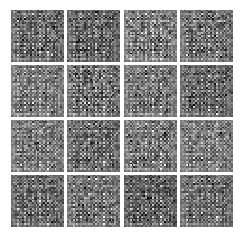


Iter: 250, D: 10.94, G:26.97


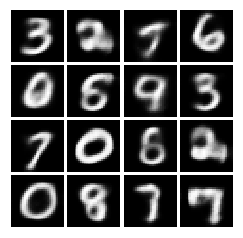


Iter: 500, D: 10.64, G:21.74


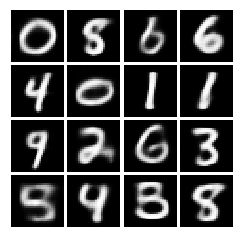


Iter: 750, D: 11.33, G:19.38


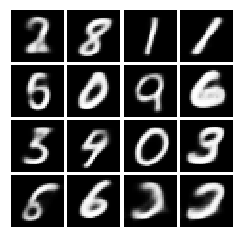


Iter: 1000, D: 11.46, G:16.55


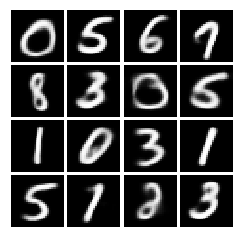


Iter: 1250, D: 11.28, G:17.48


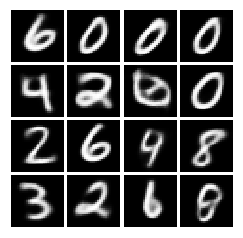


Iter: 1500, D: 11.76, G:17.61


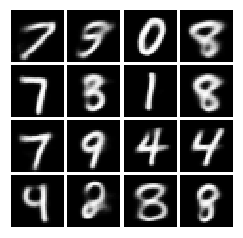


Iter: 1750, D: 12.11, G:16.44


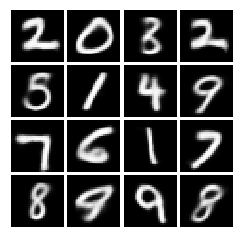


Iter: 2000, D: 11.67, G:17.65


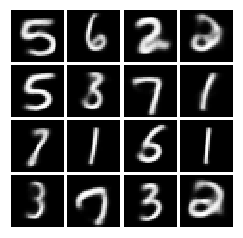


Iter: 2250, D: 11.78, G:16.8


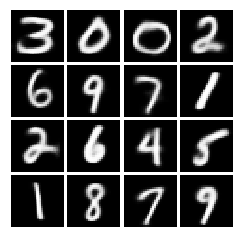


Iter: 2500, D: 12.02, G:15.6


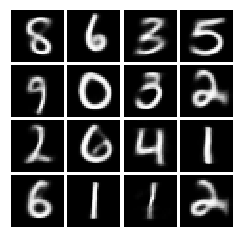


Iter: 2750, D: 12.29, G:15.9


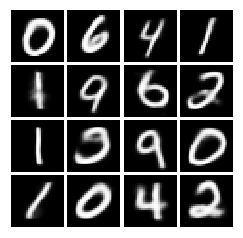


Iter: 3000, D: 12.76, G:15.88


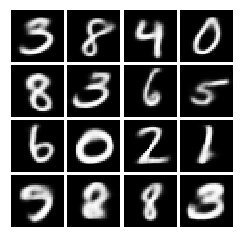


Iter: 3250, D: 12.02, G:15.48


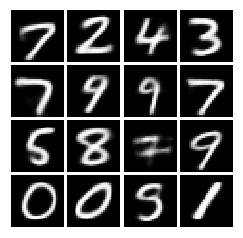


Iter: 3500, D: 12.74, G:16.16


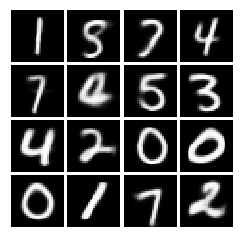


Iter: 3750, D: 11.68, G:15.08


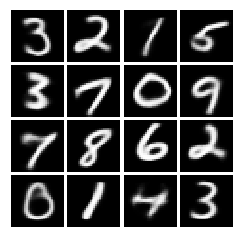

In [206]:
E_MEAN = encoder_mean().type(dtype) 
E_MEAN.apply(initialize_weights)
E_VAR = encoder_var().type(dtype)
E_VAR.apply(initialize_weights)
DEC = decoder().type(dtype)
DEC.apply(initialize_weights)

E_MEAN_solver = get_optimizer(E_MEAN)
E_VAR_solver = get_optimizer(E_VAR)
DEC_solver = get_optimizer(DEC)

run_a_vae(E_MEAN, E_VAR, DEC, E_MEAN_solver, E_VAR_solver, DEC_solver, KL_divergence_loss, Resconstruct_loss, num_epochs=20)